In [1]:
import argparse
import os
import warnings
import yaml
import sys
sys.path.append('/home/pasti/PycharmProjects/Robot_CLOD/')

import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import TQDMProgressBar
from pytorch_lightning.accelerators import find_usable_cuda_devices
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from nanodet.data.collate import naive_collate
from nanodet.data.dataset import build_dataset
from nanodet.evaluator import build_evaluator
from nanodet.trainer.task import TrainingTask
from nanodet.trainer.latent_dist_task import LatentDistTrainingTask
from torchvision.transforms import ToTensor, ToPILImage
from nanodet.util import (
    NanoDetLightningLogger,
    cfg,
    convert_old_model,
    env_utils,
    load_config,
    load_model_weight,
    mkdir,
)
from natsort import natsorted

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict


In [2]:
for i in range(1,11):
    load_config(cfg, f'/home/pasti/PycharmProjects/Robot_CLOD/eclod/cfg/LREPtask{i}.yml') 
    train_dataset = build_dataset(cfg.data.train, "train")
    test_dataset = build_dataset(cfg.data.val, "val")
    train_test = torch.utils.data.ConcatDataset([train_dataset, test_dataset])
    sorted_dataset = natsorted(train_test, key=lambda x: x['img_info']['file_name'])
    if i == 1:
        tirod = sorted_dataset
    else:
        tirod = torch.utils.data.ConcatDataset([tirod, sorted_dataset])

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
['bag', 'bottle', 'cardboard box', 'chair', 'potted plant', 'traffic cone', 'trashcan', 'ball', 'broom', 'garden hose', 'bucket', 'bycicle', 'gardening tool']
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
['bag', 'bottle', 'cardboard box', 'chair', 'potted plant', 'traffic cone', 'trashcan', 'ball', 'broom', 'garden hose', 'bucket', 'bycicle', 'gardening tool']
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
['bag', 'bottle', 'cardboard box', 'chair', 'potted plant', 'traffic cone', 'trashcan', 'ball', 'broom', 'garden hose', 'bucket', 'bycicle', 'gardening tool']
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
['bag', 'bottle', 'cardboard box', 'chair', 'potted plant', 'traffic cone', 'trashcan', 'ball', 'broom', 'garden hose', 'bucket', 'bycicle', 'gardening tool']
loading annotations into memory.

In [3]:
# Initialize a defaultdict to store category counts per frame and domain
domain_frame_category_counts = defaultdict(lambda: defaultdict(int))
frame_count_per_domain = defaultdict(int)

# Populate category counts per frame and domain, and count frames per domain
for instance in tirod:
    categories = instance['gt_labels']
    file_name = instance['img_info']['file_name']
    frame_number = int(file_name.split('_frame')[-1].replace('.png', ''))
    domain = file_name.split('_frame')[0]  # Extract domain, e.g., 'd1_h'

    for category in categories:
        domain_frame_category_counts[category][(domain, frame_number)] += 1

    frame_count_per_domain[domain] = max(frame_count_per_domain[domain], frame_number)

print(domain_frame_category_counts[5])
# Calculate the cumulative frame count per domain for vertical lines


defaultdict(<class 'int'>, {('d1_h', 1): 4, ('d1_h', 2): 4, ('d1_h', 3): 4, ('d1_h', 4): 4, ('d1_h', 5): 4, ('d1_h', 6): 4, ('d1_h', 7): 4, ('d1_h', 8): 4, ('d1_h', 9): 3, ('d1_h', 11): 3, ('d1_h', 12): 3, ('d1_h', 13): 3, ('d1_h', 14): 3, ('d1_h', 15): 3, ('d1_h', 16): 3, ('d1_h', 17): 2, ('d1_h', 18): 2, ('d1_h', 19): 2, ('d1_h', 21): 2, ('d1_h', 22): 2, ('d1_h', 23): 2, ('d1_h', 24): 2, ('d1_h', 25): 2, ('d1_h', 26): 2, ('d1_h', 27): 2, ('d1_h', 28): 5, ('d1_h', 29): 2, ('d1_h', 31): 2, ('d1_h', 32): 1, ('d1_h', 33): 1, ('d1_h', 34): 1, ('d1_h', 35): 1, ('d1_h', 36): 2, ('d1_h', 37): 1, ('d1_h', 38): 1, ('d1_h', 39): 1, ('d1_h', 41): 1, ('d1_h', 42): 1, ('d1_h', 43): 1, ('d1_h', 44): 1, ('d1_h', 69): 1, ('d1_h', 71): 1, ('d1_h', 72): 1, ('d1_h', 73): 1, ('d1_h', 74): 1, ('d1_h', 75): 1, ('d1_h', 76): 1, ('d1_h', 77): 1, ('d1_h', 78): 1, ('d1_h', 79): 1, ('d1_h', 81): 1, ('d1_h', 82): 1, ('d1_h', 83): 1, ('d1_h', 84): 1, ('d1_h', 87): 1, ('d1_h', 88): 1, ('d1_h', 89): 1, ('d1_h', 91)

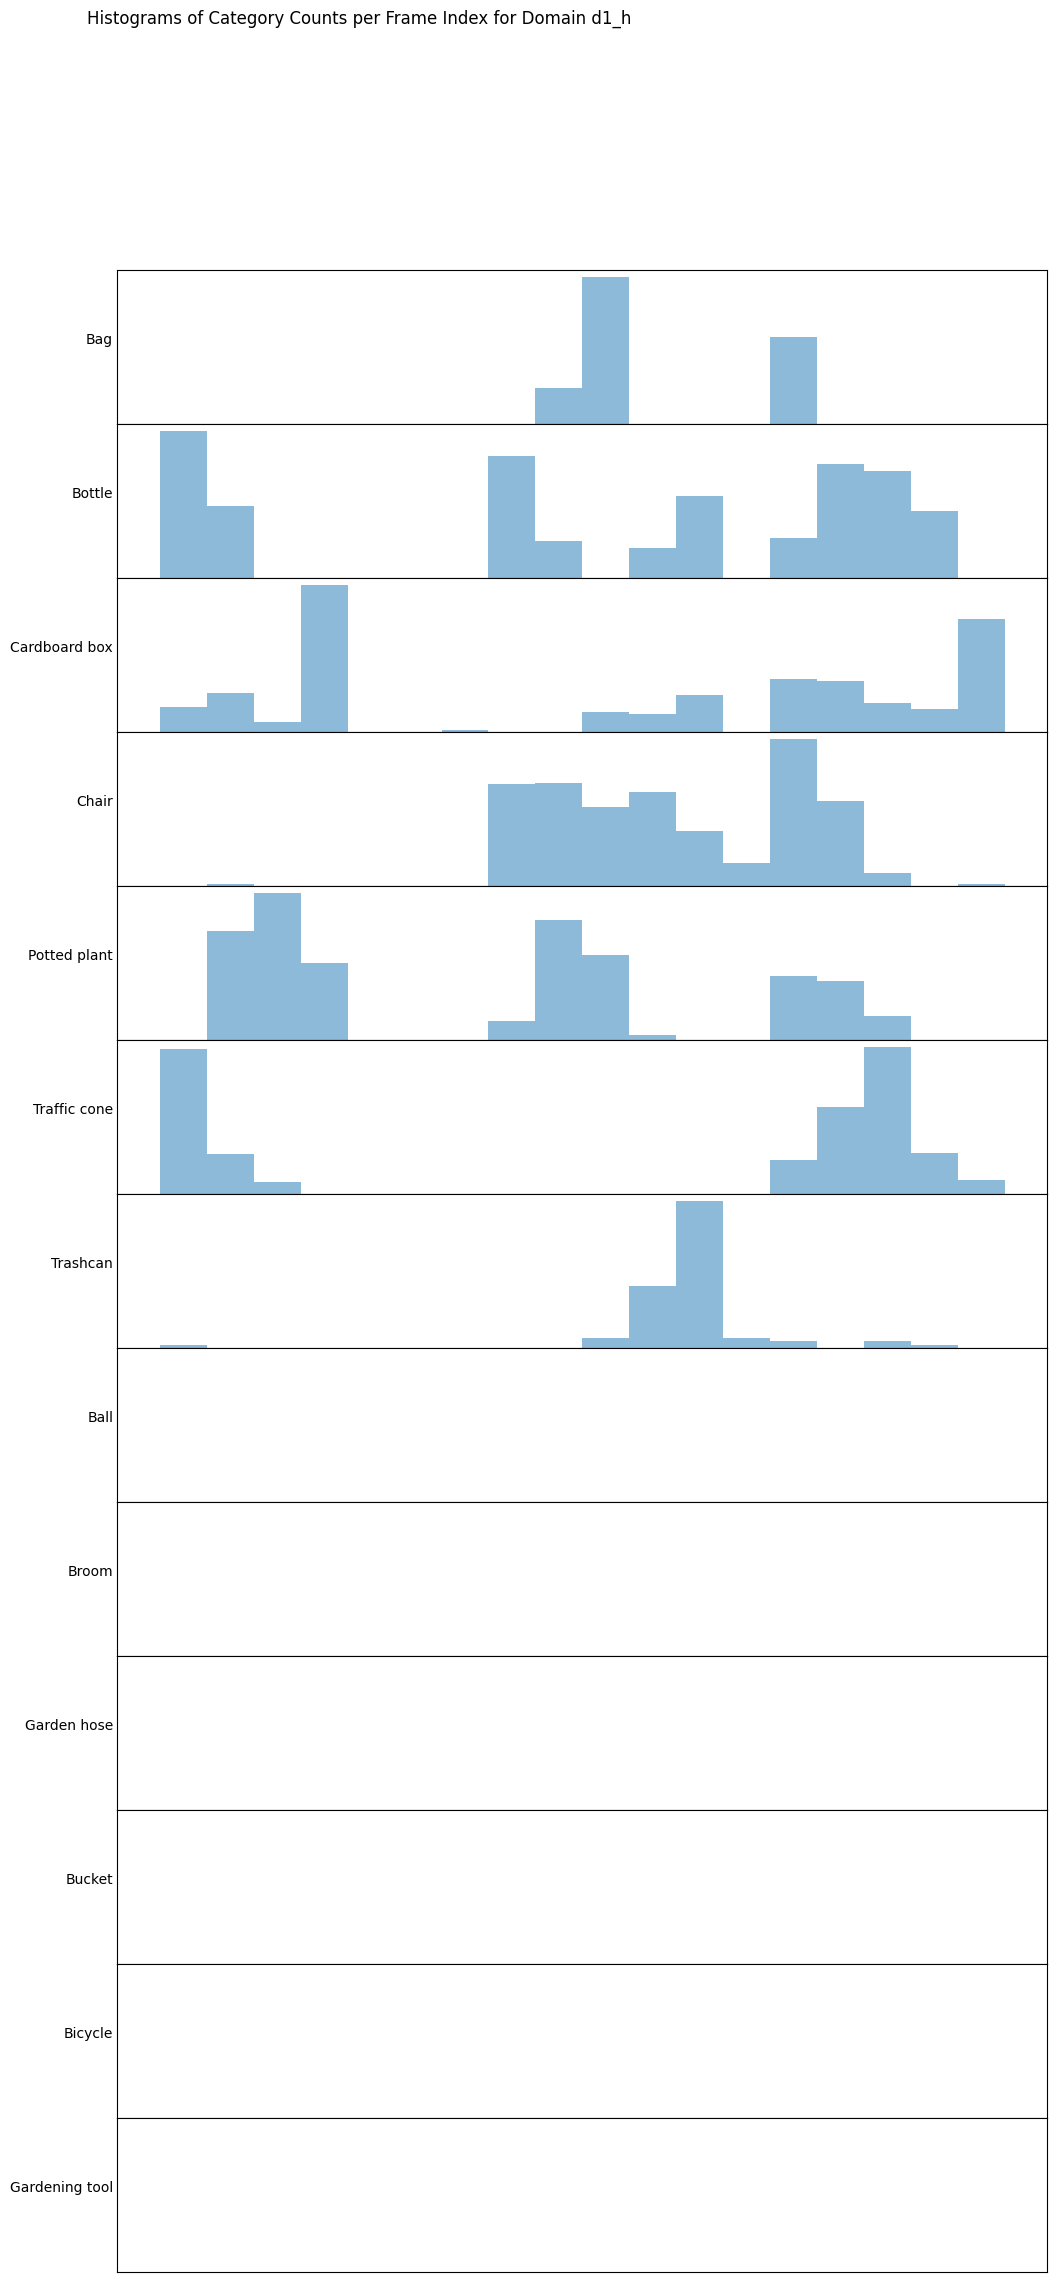

In [4]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Assuming domain_frame_category_counts is already populated

# Filter the dictionary to include only entries for domain 'd1_h'
d1_h_counts = {
    category: {key: value for key, value in counts.items() if key[0] == 'd1_h'}
    for category, counts in domain_frame_category_counts.items()
}

# Define the frame range and bins
frame_bins = list(range(0, 914, 50))  # Bins every 50 frames

# Prepare the histogram data
hist_data = defaultdict(lambda: [0] * (len(frame_bins) - 1))

for category, counts in d1_h_counts.items():
    for (domain, frame), count in counts.items():
        if domain == 'd1_h':
            bin_index = min(len(frame_bins) - 2, frame // 50)
            hist_data[category][bin_index] += count

# Category names
category_names = [
    'Bag', 'Bottle', 'Cardboard box', 'Chair', 'Potted plant', 'Traffic cone', 
    'Trashcan', 'Ball', 'Broom', 'Garden hose', 'Bucket', 'Bicycle', 'Gardening tool'
]

# Plot the histograms
num_categories = 13  # Categories go from 0 to 12
fig, axes = plt.subplots(num_categories, 1, figsize=(12, 2 * num_categories), sharex=True)

if num_categories == 1:
    axes = [axes]

for category in range(num_categories):
    counts = hist_data.get(category, [0] * (len(frame_bins) - 1))
    ax = axes[category]
    ax.bar(frame_bins[:-1], counts, width=50, alpha=0.5)
    ax.set_ylabel(category_names[category], rotation=0, labelpad=3, ha='right')
    ax.set_xticks([])
    ax.set_yticks([])

plt.subplots_adjust(hspace=0.0)  # Reduce space between plots
plt.suptitle('Histograms of Category Counts per Frame Index for Domain d1_h', x=0.1, ha='left')
plt.show()

In [6]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from collections import defaultdict

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "text.usetex": False,  # Disable LaTeX rendering
    "axes.unicode_minus": False,
    "font.size": 15,
    "pdf.fonttype": 42,  # Ensure Type 1 fonts are used
    "ps.fonttype": 42    # Ensure Type 1 fonts are used
})


# Define the domains
domains = [f'd{i}_{j}' for i in range(1, 6) for j in ['h', 'l']]

# Define the frame ranges for each domain
frame_ranges = {
    'd1_h': range(0, 914, 100),
    'd1_l': range(0, 680, 100),
    'd2_h': range(0, 681, 100),
    'd2_l': range(0, 626, 100),
    'd3_h': range(0, 799, 100),
    'd3_l': range(0, 719, 100),
    'd4_h': range(0, 674, 100),
    'd4_l': range(0, 642, 100),
    'd5_h': range(0, 515, 100),
    'd5_l': range(0, 414, 100),
}

# Prepare the histogram data
hist_data = defaultdict(lambda: defaultdict(lambda: [0] * (len(frame_ranges['d1_h']) - 1)))

for category, counts in domain_frame_category_counts.items():
    for (domain, frame), count in counts.items():
        if domain in domains:
            frame_bins = list(frame_ranges[domain])
            bin_index = min(len(frame_bins) - 2, frame // 100)
            hist_data[category][domain][bin_index] += count

# Category names
category_names = [
    'Bag', 'Bottle', 'Cardboard box', 'Chair', 'Potted plant', 'Traffic cone', 
    'Trashcan', 'Ball', 'Broom', 'Garden hose', 'Bucket', 'Bicycle', 'Gardening tool'
]

# Plot the histograms
num_categories = 13  # Categories go from 0 to 12
num_domains = len(domains)

# Calculate the relative widths of the columns based on the number of frames in each domain
col_widths = [len(frame_ranges[domain]) for domain in domains]

fig = plt.figure(figsize=(sum(col_widths) * 0.3, (num_categories + 2) * 0.7))
gs = GridSpec(num_categories + 2, num_domains, width_ratios=col_widths)

# Add the "High" and "Low" rows
for domain_index, domain in enumerate(domains):
    if 'h' in domain:
        ax_high = fig.add_subplot(gs[0, domain_index])
        ax_high.set_facecolor('lightgrey')
        ax_high.axhline(y=0.6, color='coral', linewidth=30)
        ax_high.set_xticks([])
        ax_high.set_yticks([])
        ax_high.spines['top'].set_visible(False)
        ax_high.spines['right'].set_visible(False)
        ax_high.spines['bottom'].set_visible(False)
        ax_high.spines['left'].set_visible(False)
        if domain_index == 0:
            ax_high.set_ylabel('High', rotation=0, labelpad=5, ha='right', fontsize=15)
        ax_high.axvline(x=1, color='black', linestyle='--', linewidth=3, zorder=10)
        ax_low = fig.add_subplot(gs[1, domain_index])
        ax_low.set_facecolor('lightgrey')
        ax_low.set_xticks([])
        ax_low.set_yticks([])
        ax_low.spines['top'].set_visible(False)
        ax_low.spines['right'].set_visible(False)
        ax_low.spines['bottom'].set_visible(False)
        ax_low.spines['left'].set_visible(False)
        if domain_index == 0:
            ax_low.set_ylabel('Low', rotation=0, ha='right', fontsize=15)
        ax_low.axvline(x=1, color='black', linestyle='--', linewidth=3, zorder=10)

    else:
        ax_low = fig.add_subplot(gs[1, domain_index])
        ax_low.set_facecolor('lightgrey')
        ax_low.axhline(y=0.6, color='cornflowerblue', linewidth=30)
        ax_low.set_xticks([])
        ax_low.set_yticks([])
        ax_low.spines['top'].set_visible(False)
        ax_low.spines['right'].set_visible(False)
        ax_low.spines['bottom'].set_visible(False)
        ax_low.spines['left'].set_visible(False)
        ax_low.axvline(x=1, color='black', linestyle='--', linewidth=3, zorder=10)
        ax_high = fig.add_subplot(gs[0, domain_index])
        ax_high.set_facecolor('lightgrey')
        ax_high.set_xticks([])
        ax_high.set_yticks([])
        ax_high.spines['top'].set_visible(False)
        ax_high.spines['right'].set_visible(False)
        ax_high.spines['bottom'].set_visible(False)
        ax_high.spines['left'].set_visible(False)
        ax_high.axvline(x=1, color='black', linestyle='--', linewidth=3, zorder=10)
    ax_high.text(1, 1.2, domain, ha='center', va='bottom', color='black', zorder= 10)
# Plot the category histograms
for category in range(num_categories):
    max_y = 0  # Initialize the maximum y-limit for the current category
    for domain_index, domain in enumerate(domains):
        frame_bins = list(frame_ranges[domain])
        counts = hist_data[category].get(domain, [0] * (len(frame_bins) - 1))
        max_count = max(counts) if counts else 1  # Avoid division by zero
        if max_count == 0:
            normalized_counts = [0] * len(counts)
        else:
            normalized_counts = [count / max_count for count in counts]
        ax = fig.add_subplot(gs[category + 2, domain_index])
        #ax.set_facecolor('lightgrey')
        ax.bar(frame_bins[:-1], normalized_counts[:len(frame_bins) - 1], width=100, alpha=0.5, align='edge', color='forestgreen') 
        ax.set_xlim(0, max(frame_bins))  # Set x-axis limits to the frame range
        if domain_index == 0:
            ax.set_ylabel(category_names[category], rotation=0, labelpad=5, ha='right',  fontsize=15)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
        line_position = max(frame_bins)
        ax.axvline(x=line_position, ymin=0, ymax=1, color='black', linestyle='--', linewidth=3, zorder=10)
        
        # Update the maximum y-limit for the current category
        max_y = max(max_y, max(counts))
        if domain_index == num_domains-1:
            ax.set_ylabel(str(max_y), rotation=0, fontsize=15)
            ax.yaxis.set_label_coords(1.17, 0.85)
            ax.axhline(y=1.11, xmin=0.9, xmax=1.2, color='black', linewidth=2)

# Add y-axis labels for the "High" and "Low" rows
fig.text(0.04, 0.83, 'ILLUMINATION', va = 'center', rotation='vertical', fontsize=18, fontweight='bold')

# Add y-axis labels for the category rows
fig.text(0.04, 0.4, 'CATEGORIES', va='center', rotation='vertical', fontsize=18, fontweight='bold')

plt.subplots_adjust(hspace=0.0, wspace=0.0)  # Reduce space between plots to 0
plt.savefig('dataset.pdf', format='pdf',  bbox_inches='tight')
plt.show()


RuntimeError: Failed to process string with tex because latex could not be found

Error in callback <function _draw_all_if_interactive at 0x7f78cf1b3370> (for post_execute):


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 2160x1050 with 150 Axes>